In [1]:
from kan_convs import FastKANConv1DLayer
from kans import FastKAN
import numpy as np
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Ninh Tri\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = FastKANConv1DLayer(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = FastKAN([out_channels], use_base_update=False)
        self.conv2 = FastKANConv1DLayer(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        # out = self.relu(out)

        return out

In [4]:
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = FastKANConv1DLayer(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = FastKAN([64], use_base_update=False)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = FastKAN([512, num_classes], use_base_update=False)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                FastKANConv1DLayer(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        # x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [5]:
model = ResNet1D(BasicBlock, [2, 2, 2, 2])

In [6]:
dict(model.named_modules())

{'': ResNet1D(
   (conv1): FastKANConv1DLayer(
     (base_activation): SiLU()
     (base_conv): ModuleList(
       (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
     )
     (spline_conv): ModuleList(
       (0): Conv1d(8, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
     )
     (layer_norm): ModuleList(
       (0): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     )
     (rbf): RadialBasisFunction()
   )
   (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): FastKAN(
     (layers): ModuleList()
   )
   (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): FastKANConv1DLayer(
         (base_activation): SiLU()
         (base_conv): ModuleList(
           (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
         )
         (spline_conv): 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.collections as mcoll
import cv2

In [8]:
from gradcam2 import plotting

(106,)


<Figure size 500x100 with 0 Axes>

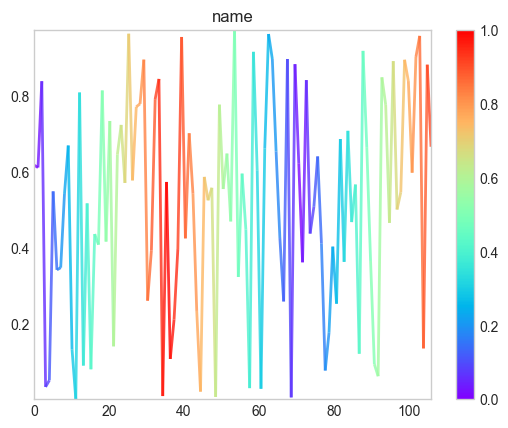

In [9]:
plotting(model, 'layer4', torch.rand(1, 106), 106, 'name')

In [10]:
layer = model.fc.layers[0]
layer

FastKANLayer(
  (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (rbf): RadialBasisFunction()
  (spline_linear): SplineLinear(in_features=4096, out_features=5, bias=False)
)

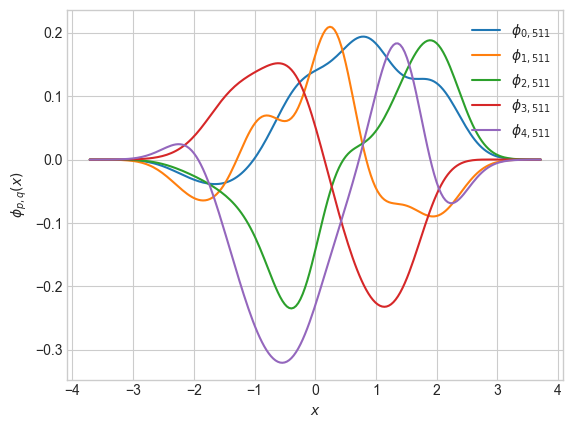

In [11]:
for i in range(5):
    for j in range(512):
        x, y = None, None
        if x is None and y is None:
            x, y = layer.plot_curve(j, i, 200, num_extrapolate_bins=3)
        else:
            _, y_tmp = layer.plot_curve(j, i, 200, num_extrapolate_bins=3)
            y+=y_tmp
    plt.plot(x.numpy(), y.numpy(), label=r"$\phi_{" + f"{i},{j}" + r"}$")
plt.xlabel("$x$")
plt.ylabel("$\phi_{p,q}(x)$")
plt.legend(loc="upper right")